In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

os.chdir('/Volumes/GoogleDrive/My Drive/BEAM-CORE/BEAM Validation')

plt.style.use('ggplot')
scenario_name = 'Oakland2021'

In [2]:
# load austin radar data for validation
link_to_NPMRDS_data = 'data for validation/SF/NPMRDS/'
NPMRDS_data_file = 'sf_npmrds_data.csv'
oakland_NPMRDS_file = 'oakland_npmrds_stations.csv'
SF_NPMRDS_data = read_csv(link_to_NPMRDS_data + NPMRDS_data_file, sep = ',')
oakland_NPMRDS_stations = read_csv(link_to_NPMRDS_data + oakland_NPMRDS_file, sep = ',')
# load BEAM output
modeled_vmt = read_csv('sample output/Oakland2021/0.linkstats.csv.gz', low_memory=False)
model_network = read_csv('sample output/Oakland2021/beam_network_npmrds_screenline_oak.csv', low_memory=False)

SF_NPMRDS_data.head(5)

,Unnamed: 0,tmc_code,measurement_tstamp,speed,average_speed,reference_speed,travel_time_seconds
0,1,105N13022,2018-10-01 06:00:00,16.25,13.0,38.0,13.25
1,2,105N13022,2018-10-01 07:00:00,14.40,12.0,38.0,14.95
2,3,105N13022,2018-10-01 08:00:00,9.54,9.0,38.0,22.57
3,4,105N13022,2018-10-01 09:00:00,15.03,10.0,38.0,14.33
4,5,105N13022,2018-10-01 10:00:00,29.47,10.0,38.0,7.31


In [3]:
# select observed data for validation
list_of_tmcs = model_network.loc[:, 'Tmc'].unique()
SF_NPMRDS_data = SF_NPMRDS_data.loc[SF_NPMRDS_data['tmc_code'].isin(list_of_tmcs)]
SF_NPMRDS_data.loc[:, 'formatted_time'] =pd.to_datetime(SF_NPMRDS_data.loc[:, 'measurement_tstamp'], 
                                                                        format="%Y-%m-%d %H:%M:%S")
SF_NPMRDS_data.loc[:, 'weekday'] = SF_NPMRDS_data.loc[:, 'formatted_time'].dt.weekday
SF_NPMRDS_data.loc[:, 'hour'] = SF_NPMRDS_data.loc[:, 'formatted_time'].dt.hour
SF_NPMRDS_data = SF_NPMRDS_data.loc[SF_NPMRDS_data['weekday'] == 1]

SF_NPMRDS_data.loc[SF_NPMRDS_data['speed']>= 80, 'speed'] = 80

# austin_NPMRDS_data_hourly_volume = austin_NPMRDS_data.groupby(['tmc_code', 'hour'])[['flow_per_lane']].mean()
# austin_NPMRDS_data_hourly_volume.columns = ['Volume (veh/lane/hour)']
# austin_NPMRDS_data_hourly_volume = austin_NPMRDS_data_hourly_volume.reset_index()
SF_NPMRDS_data_hourly_speed = SF_NPMRDS_data.groupby(['tmc_code', 'hour'])[['speed']].mean()
SF_NPMRDS_data_hourly_speed = SF_NPMRDS_data_hourly_speed.reset_index()
SF_NPMRDS_data_hourly_speed.columns = ['Tmc', 'hour', 'Avg.Speed (mph)']

# SF_NPMRDS_data_hourly_speed = pd.merge(austin_NPMRDS_data_hourly_volume,
#                                          austin_NPMRDS_data_hourly_speed,
#                                          on = ['Tmc', 'hour'], how = 'left')
SF_NPMRDS_data_hourly_speed.head(10)

,Tmc,hour,Avg.Speed (mph)
0,105+04388,0,58.644
1,105+04388,1,53.178
2,105+04388,2,57.696
3,105+04388,3,58.036
4,105+04388,4,59.112
5,105+04388,5,57.764
6,105+04388,6,48.488
7,105+04388,7,45.066
8,105+04388,8,45.162
9,105+04388,9,44.148


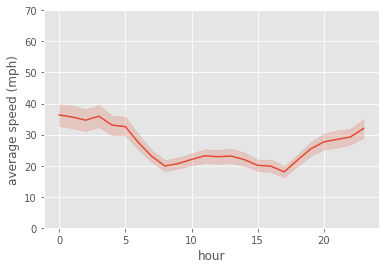

In [6]:
sns.lineplot(data = SF_NPMRDS_data_hourly_speed, x = "hour", y = "Avg.Speed (mph)", ci=95)
plt.ylim([0, 70])
plt.ylabel('average speed (mph)')
plt.savefig('plot/' + scenario_name + '/NPMRDS_hourly_mean_speed.png', bbox_inches='tight', dpi = 300)
plt.show()

In [5]:
modeled_roadtype_lookup = {'tertiary': 'Minor collector',
                           'trunk_link': 'Freeway and major arterial',
                           'residential': 'Local',
                           'track': 'Local',
                           'footway': 'Local',
                           'motorway': 'Freeway and major arterial',
                           'secondary': 'Major collector',
                           'unclassified': 'Local',
                           'path': 'Local',
                           'secondary_link': 'Major collector',
                           'primary': 'Minor arterial',
                           'motorway_link': 'Freeway and major arterial',
                           'primary_link': 'Minor arterial',
                           'trunk': 'Freeway and major arterial',
                           'pedestrian': 'Local',
                           'tertiary_link': 'Minor collector',
                           'cycleway': 'Local',
                           np.nan: 'Local',
                           'steps': 'Local',
                           'living_street': 'Local', 
                           'bus_stop': 'Local',
                           'corridor': 'Local', 
                           'road': 'Local',
                           'bridleway': 'Local'}

model_network.loc[:, 'road_class'] = model_network.loc[:, 'attributeOrigType'].map(modeled_roadtype_lookup)
tmc_county_lookup = model_network.loc[:, ['NAME', 'Tmc', 'road_class']]
tmc_county_lookup = tmc_county_lookup.drop_duplicates(subset=['Tmc'])

In [6]:
meter_to_mile = 0.000621371
percent_of_samples = 1
mps_to_mph = 2.23694
model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.head(5)

,Unnamed: 0,V1,linkId,linkLength,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,GEOID,NAME,NAMELSAD,CLASSFP,Tmc,dist_to_tmc,road_class
0,1,147,252,53.778,15.8816,750,0.5,car;walk;bike,215,secondary_link,176,177,6001,Alameda,Alameda County,H1,105+08374,0.000000,Major collector
1,2,148,253,53.778,15.8816,750,0.5,car;walk;bike,215,secondary_link,177,176,6001,Alameda,Alameda County,H1,105+08374,0.000000,Major collector
2,3,379,690,371.886,29.0576,2000,1.0,car;bike,526,motorway_link,475,476,6001,Alameda,Alameda County,H1,105-04524,1.001469,Freeway and major arterial
3,4,380,691,371.886,29.0576,2000,1.0,car;bike,526,motorway_link,476,475,6001,Alameda,Alameda County,H1,105-04524,1.001469,Freeway and major arterial
4,5,631,1206,135.532,18.1168,4400,2.0,car;walk;bike,924,secondary,832,834,6001,Alameda,Alameda County,H1,105-04599,0.000000,Major collector


In [7]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network.loc[:, 'fromNodeId'] = model_network.loc[:, 'fromNodeId'].astype(int)
model_network.loc[:, 'toNodeId'] = model_network.loc[:, 'toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network, 
                                 left_on = ['link', 'from', 'to'],
                                 right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'inner')
model_vmt_24_hour.head(5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,link,from,to,hour,length,freespeed,capacity,stat,volume,traveltime,...,attributeOrigType,fromNodeId,toNodeId,GEOID,NAME,NAMELSAD,CLASSFP,Tmc,dist_to_tmc,road_class
0,3672,2542,2543,5.0,249.099,29.057528,2300.0,AVG,876.0,8.572615,...,primary,2542,2543,6001,Alameda,Alameda County,H1,105+08350,1.034329,Minor arterial
1,3672,2542,2543,6.0,249.099,29.057528,2300.0,AVG,1585.0,8.592243,...,primary,2542,2543,6001,Alameda,Alameda County,H1,105+08350,1.034329,Minor arterial
2,3672,2542,2543,7.0,249.099,29.057528,2300.0,AVG,941.0,46.330670,...,primary,2542,2543,6001,Alameda,Alameda County,H1,105+08350,1.034329,Minor arterial
3,3672,2542,2543,8.0,249.099,29.057528,2300.0,AVG,177.0,48.933600,...,primary,2542,2543,6001,Alameda,Alameda County,H1,105+08350,1.034329,Minor arterial
4,3672,2542,2543,9.0,249.099,29.057528,2300.0,AVG,29.0,69.620597,...,primary,2542,2543,6001,Alameda,Alameda County,H1,105+08350,1.034329,Minor arterial


In [8]:
demand_scaling = 1/percent_of_samples
model_vmt_24_hour.loc[:, 'hourly volume'] = model_vmt_24_hour.loc[:, 'volume']/ \
model_vmt_24_hour.loc[:, 'numberOfLanes']
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600
model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime'] 
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']


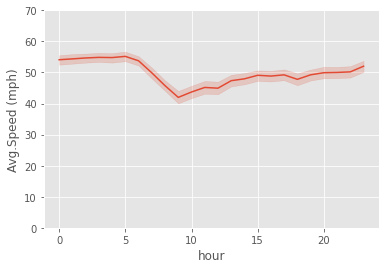

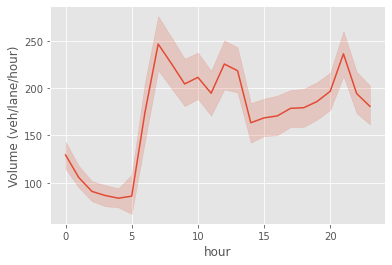

In [9]:
model_vmt_hour_volume = model_vmt_24_hour.groupby(['Tmc', 'hour'])[['hourly volume']].mean()
model_vmt_hour_volume = model_vmt_hour_volume.reset_index()
model_vmt_hour_volume.columns = ['Tmc', 'hour', 'Volume (veh/lane/hour)']
model_vmt_24_hour_filtered = model_vmt_24_hour.loc[model_vmt_24_hour['volume']>0]
model_vmt_hour_speed = model_vmt_24_hour_filtered.groupby(['Tmc', 'hour']).apply(lambda x: np.average(x.speed, weights=x.volume))
model_vmt_hour_speed = model_vmt_hour_speed.reset_index()
model_vmt_hour_speed.columns = ['Tmc', 'hour', 'Avg.Speed (mph)'] 
model_vmt_hour_speed.loc[:, 'Avg.Speed (mph)'] *= mps_to_mph

model_vmt_hour_data = pd.merge(model_vmt_hour_volume, model_vmt_hour_speed,
                               on = ['Tmc', 'hour'], how = 'left')
sns.lineplot(x = 'hour', y = 'Avg.Speed (mph)', data = model_vmt_hour_data, ci = 95)
plt.ylim([0, 70])
plt.savefig('plot/' + scenario_name + '/modeled_speed_NPMRDS_screenline.png', dpi = 200)
plt.show()

sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', data = model_vmt_hour_data, ci = 95)
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt.savefig('plot/' + scenario_name + '/SF2014_modeled_volume_NPMRDS_screenline.png', dpi = 200)
plt.show()

In [10]:
# compare two datasets
SF_NPMRDS_data_hourly_speed.loc[:, 'source'] = 'NPMRDS'
model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data = pd.concat([SF_NPMRDS_data_hourly_speed, model_vmt_hour_data])
combined_data = combined_data.reset_index()
combined_data.head(5)

,index,Tmc,hour,Avg.Speed (mph),source,Volume (veh/lane/hour)
0,0,105+04388,0.0,58.644,NPMRDS,NaN
1,1,105+04388,1.0,53.178,NPMRDS,NaN
2,2,105+04388,2.0,57.696,NPMRDS,NaN
3,3,105+04388,3.0,58.036,NPMRDS,NaN
4,4,105+04388,4.0,59.112,NPMRDS,NaN


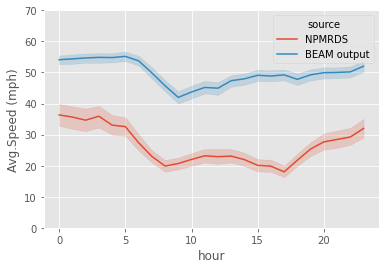

In [12]:
sns.lineplot(x = 'hour', y = 'Avg.Speed (mph)', hue = 'source', data = combined_data, ci = 95)
plt.ylim([0, 70])
plt.savefig('plot/' + scenario_name + '/BEAM_NPMRDS_screenline_speed_validation.png', dpi = 200)
plt.show()

# sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', hue = 'source', data = combined_data, ci = 95)
# # plt.ylim([0, 70])
# # plt.ylabel('volume (veh/lane/hour)')
# plt.savefig('plot/aus2017_BEAM_NPMRDS_screenline_volume_validation.png', dpi = 200)
# plt.show()

In [11]:
paired_data_for_comparison = pd.merge(SF_NPMRDS_data_hourly_speed, model_vmt_hour_data,
                                      on = ['Tmc', 'hour'], how = 'left')

paired_data_for_comparison = pd.merge(paired_data_for_comparison, tmc_county_lookup, 
                                      on = 'Tmc', how = 'left')
paired_data_for_comparison = paired_data_for_comparison.rename(columns = {'Avg.Speed (mph)_x': 'SF NPMRDS speed',
                                                                         'Avg.Speed (mph)_y': 'BEAM speed'})
paired_data_for_comparison = paired_data_for_comparison.dropna(subset = ['BEAM speed'])
# paired_data_for_comparison["KITS ID"] = paired_data_for_comparison["KITS ID"].astype(str)
paired_data_for_comparison.head(5)

,Tmc,hour,SF NPMRDS speed,source_x,Volume (veh/lane/hour),BEAM speed,source_y,NAME,road_class
0,105+04388,0,58.644,NPMRDS,283.5,50.308331,BEAM output,Alameda,Major collector
1,105+04388,1,53.178,NPMRDS,249.5,58.575891,BEAM output,Alameda,Major collector
2,105+04388,2,57.696,NPMRDS,191.5,56.087418,BEAM output,Alameda,Major collector
3,105+04388,3,58.036,NPMRDS,191.0,55.167073,BEAM output,Alameda,Major collector
4,105+04388,4,59.112,NPMRDS,212.0,59.333869,BEAM output,Alameda,Major collector


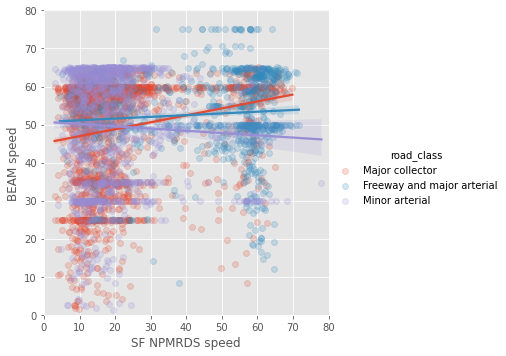

In [12]:
# sns.regplot(data=paired_data_for_comparison, x="Austin NPMRDS volume", y="BEAM volume",
#            scatter_kws={"color": "black", 'alpha':0.5})
# plt.xlim([0, 6000])
# plt.ylim([0, 6000])
# plt.savefig('plot/aus2017_paired_NPMRDS_screenline_volume_validation.png', dpi = 200)
# plt.show()
sns.lmplot(data=paired_data_for_comparison, x="SF NPMRDS speed", y="BEAM speed",
           hue = 'road_class',
           scatter_kws={'alpha':0.2})
plt.xlim([0, 80])
plt.ylim([0, 80])
plt.savefig('plot/' + scenario_name + '/paired_NPMRDS_screenline_speed_validation.png', dpi = 200)
plt.show()

In [15]:
paired_data_to_check = paired_data_for_comparison.loc[(paired_data_for_comparison['BEAM speed']<=5) & \
                                                      (paired_data_for_comparison['SF NPMRDS speed']>= 50)]
paired_data_to_check = pd.merge(paired_data_to_check,
                                model_vmt_24_hour_filtered,
                                on = ['Tmc', 'hour'], how = 'left')
paired_data_to_check = paired_data_to_check.loc[paired_data_to_check['speed (mph)'] <= 5]
paired_data_to_check.to_csv('sample output/SFB2014/selected_link_to_check.csv')

paired_data_to_check.head(5)



,Tmc,hour,SF NPMRDS speed,Volume (veh/lane/hour),BEAM speed,link,from,to,length,freespeed,...,toNodeId,GEOID,NAME,NAMELSAD,CLASSFP,dist_to_tmc,hourly volume,VMT,speed,speed (mph)
0,105+04206,0,57.8000,250.0,0.576906,16095,9858,9857,109.536,29.0576,...,9857,6041,Marin,Marin County,H1,0.0,250.0,85.078117,0.257915,0.576941
1,105+04206,0,57.8000,250.0,0.576906,16094,9857,9858,109.536,29.0576,...,9858,6041,Marin,Marin County,H1,0.0,250.0,85.078117,0.257884,0.576871
2,105+04206,1,56.9825,249.0,0.575077,16095,9858,9857,109.536,29.0576,...,9857,6041,Marin,Marin County,H1,0.0,250.0,85.078117,0.257915,0.576941
3,105+04206,1,56.9825,249.0,0.575077,16094,9857,9858,109.536,29.0576,...,9858,6041,Marin,Marin County,H1,0.0,248.0,84.397492,0.256242,0.573198
4,105+04206,2,59.9680,250.0,0.577362,16095,9858,9857,109.536,29.0576,...,9857,6041,Marin,Marin County,H1,0.0,250.0,85.078117,0.258292,0.577784


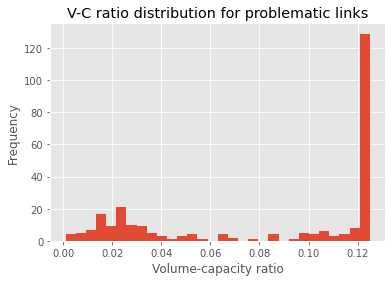

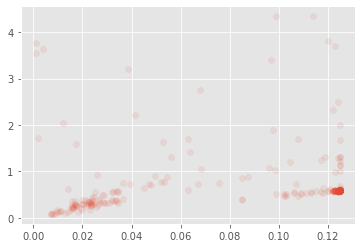

In [19]:
paired_data_to_check.loc[:, 'capacity per lane'] = paired_data_to_check.loc[:, 'capacity'] / paired_data_to_check.loc[:, 'numberOfLanes']
paired_data_to_check.loc[:, 'V-C Ratio'] = paired_data_to_check.loc[:, 'hourly volume']/paired_data_to_check.loc[:, 'capacity per lane']
paired_data_to_check.loc[:, 'V-C Ratio'].hist(bins = 30)
plt.xlabel('Volume-capacity ratio')
plt.ylabel('Frequency')
plt.title('V-C ratio distribution for problematic links')
plt.savefig('plot/vc_ratio_for_problematic_links.png', dpi = 200)
plt.show()
plt.scatter(x='V-C Ratio', y = 'speed (mph)', data = paired_data_to_check, alpha = 0.1)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


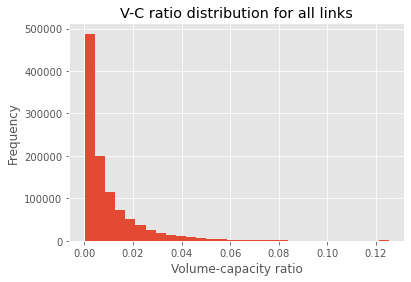

In [21]:
# filter network congested part
model_vmt_24_hour_filtered.loc[:, 'capacity per lane'] = model_vmt_24_hour_filtered.loc[:, 'capacity'] / model_vmt_24_hour_filtered.loc[:, 'numberOfLanes']
model_vmt_24_hour_filtered.loc[:, 'V-C Ratio'] = model_vmt_24_hour_filtered.loc[:, 'hourly volume'] / model_vmt_24_hour_filtered.loc[:, 'capacity per lane']
model_vmt_24_hour_filtered.loc[:, 'V-C Ratio'].hist(bins = 30)
plt.xlabel('Volume-capacity ratio')
plt.ylabel('Frequency')
plt.title('V-C ratio distribution for all links')
plt.savefig('plot/vc_ratio_for_all_sf_links.png', dpi = 200)
plt.show()                               

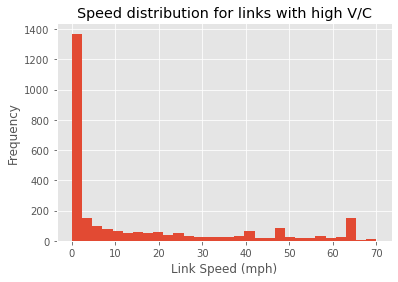

In [23]:
model_vmt_24_hour_congested = model_vmt_24_hour_filtered.loc[model_vmt_24_hour_filtered['V-C Ratio']>= 0.1]
model_vmt_24_hour_congested.loc[:, 'speed (mph)'].hist(bins = 30)
plt.xlabel('Link Speed (mph)')
plt.ylabel('Frequency')
plt.title('Speed distribution for links with high V/C')
plt.savefig('plot/speed_for_congested_sf_links.png', dpi = 200)
plt.show() 

model_vmt_24_hour_congested.to_csv('sample output/SFB2014/links_with_high_vc.csv')

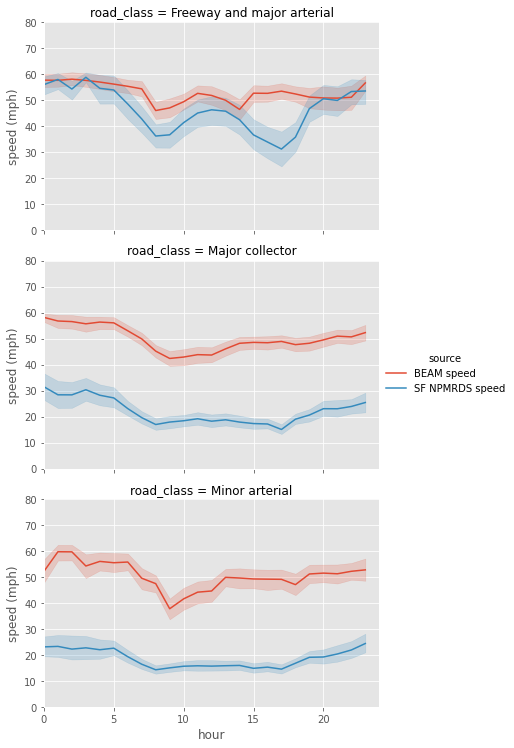

In [13]:
paired_data_by_county_melt = pd.melt(paired_data_for_comparison, 
                                    id_vars = ['Tmc', 'hour', 'road_class'],
                                    value_vars = ["SF NPMRDS speed", "BEAM speed"], 
                                    var_name = 'source',
                                    value_name = 'speed (mph)')
paired_data_by_county_melt = paired_data_by_county_melt.reset_index()
paired_data_by_county_melt = paired_data_by_county_melt.sort_values('road_class')
sns.relplot(data = paired_data_by_county_melt, x = "hour", y = "speed (mph)",
                hue = 'source', row = 'road_class',
                kind="line", height = 3.5, aspect = 1.6)
plt.xlim([0, 24])
plt.ylim([0, 80])
#     plt.title('County = ' + county + ', R2 = ' + str(r2_value))
plt.savefig('plot/' + scenario_name + '/paired_NPMRDS_hourly_speed_from_oakland.png', dpi = 200, bbox_inches = 'tight')
plt.show()